# Probabilistic Stock Analysis 

"Man is a deterministic device in a probabilistic universe" - Amos Tversky & Danny Kahneman 

This experiment is based on an idea which the two aforementioned Israeli psychologists researched: that though the human mind can solve incredibly complex problems, like vision, it is systematically erred when forced to make simpler probabilistic judgements. Like investing! 

Our minds are particularly susceptible to warping current decisions based on the availability of recent events. For example, if a company puts out a good earnings report for their previous quarter, everyone rushes to invest. But most of those same people will tell you that the past behavior of a stock tells you nothing about its future.  With an investment strategy, we want to make money regardless of changes to tax codes or whether there is a coup in Turkey. If a stock can be treated more like a random variable, we can root out the probabilistic nature of its behavior, and resist the fallacies in our thinking. 

The idea here is to build a model, or at least a mode of thinking, that allows us to maximize the usefulness of our thinking, and minimize its errs. We want retain our native intuition in understanding underlying market trends, assessing the executives running their companies, and calculating how basic economics or sociology affects a broad market. We also want to reduce the foibles of probablistic thinking by building models and visualizations that will abstract stochasticity into simple statistical truths.

In [6]:
#import necessary libraries 
import pandas as pd 
import numpy as np
import os 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sb
import time
from datetime import datetime, timedelta

pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 30
%matplotlib inline
sb.set_style("ticks")

# Data Aquision and Preprocessing: 

A new function to scrape stock data from Yahoo Finance, since YF killed their python API.

In [7]:
# https://stackoverflow.com/questions/43149200/python-and-yahoo-finance-weird-yqlqueryerrorresponseerrordescription/44271722#44271722
# ^credit where credit due. 
import urllib2
from BeautifulSoup import BeautifulSoup as bs

def get_historical_data(name, number_of_days):
    data = []
    date = []
    url = "https://finance.yahoo.com/quote/" + name + "/history/"
    rows = bs(urllib2.urlopen(url).read()).findAll('table')[1].tbody.findAll('tr')
    
    for each_row in rows:
        divs = each_row.findAll('td')
        if divs[1].span.text  != 'Dividend': #Ignore this row in the table
            
            #for other values, play with divs[1 - 5]
            open_price = float(divs[5].span.text.replace(',',''))
            date_share =  str(divs[0].span.text) #grab date from html table 
            date_share = str(datetime.strptime(date_share,  "%b %d, %Y"))[:10] #convert to datetime object to reformat
            data.append(open_price)
            date.append(date_share)
    dummy = np.array([np.linspace(0, number_of_days-1, number_of_days)]).T
    data = np.array([data]).T
    data = data[:number_of_days]
    date = date[:number_of_days]
    
    data = np.append(dummy,data, axis=1)
    
    return pd.DataFrame(data=data, index=date, columns=['dummy', name+'_adj'])

# TEST
#get_historical_data('tsla', 56)

In [8]:
# for plotting pretty graphs 

def rgb(x): #rgb picker 
    out = float(x)/256.0
    return out

In [9]:
#S&P 500 - scraped from wikipedia -- Separate .py file 
# , 'abbv', 'bf' #stocks w annoying tickers...
sp500 = ['Date', 'mmm', 'abt', 'acn', 'atvi', 'ayi', 'adbe', 'amd', 'aap', 'aes', 'aet', 'amg', 'afl',
         'a', 'apd', 'akam', 'alk', 'alb', 'are', 'agn', 'lnt', 'alxn', 'alle', 'ads', 'all', 'googl',
         'goog', 'mo', 'amzn', 'aee', 'aal', 'aep', 'axp', 'aig', 'amt', 'awk', 'amp', 'abc', 'ame',
         'amgn', 'aph', 'apc', 'adi', 'antm', 'aon', 'apa', 'aiv', 'aapl', 'amat', 'adm', 'arnc', 'ajg',
         'aiz', 't', 'adsk', 'adp', 'an', 'azo', 'avb', 'avy', 'bhi', 'bll', 'bac', 'bk', 'bcr', 'bax',
         'bbt', 'bdx', 'bbby', 'brk', 'bby', 'biib', 'blk', 'hrb', 'ba', 'bwa', 'bxp', 'bsx', 'bmy', 
         'avgo', 'chrw', 'ca', 'cog', 'cpb', 'cof', 'cah', 'cboe', 'kmx', 'ccl', 'cat', 'cbg', 'cbs',
         'celg', 'cnc', 'cnp', 'ctl', 'cern', 'cf', 'schw', 'chtr', 'chk', 'cvx', 'cmg', 'cb', 'chd', 'ci', 
         'xec', 'cinf', 'ctas', 'csco', 'c', 'cfg', 'ctxs', 'clx', 'cme', 'cms', 'coh', 'ko', 'ctsh', 'cl', 
         'cmcsa', 'cma', 'cag', 'cxo', 'cop', 'ed', 'stz', 'glw', 'cost', 'coty', 'cci', 'csra', 'csx', 'cmi',
         'cvs', 'dhi', 'dhr', 'dri', 'dva', 'de', 'dlph', 'dal', 'xray', 'dvn', 'dlr', 'dfs', 'disca', 'disck',
         'dish', 'dg', 'dltr', 'd', 'dov', 'dow', 'dps', 'dte', 'dd', 'duk', 'dnb', 'etfc', 'emn', 'etn', 'ebay',
         'ecl', 'eix', 'ew', 'ea', 'emr', 'etr', 'evhc', 'eog', 'eqt', 'efx', 'eqix', 'eqr', 'ess', 'el', 'es',
         'exc', 'expe', 'expd', 'esrx', 'exr', 'xom', 'ffiv', 'fb', 'fast', 'frt', 'fdx', 'fis', 'fitb', 'fe', 
         'fisv', 'flir', 'fls', 'flr', 'fmc', 'fti', 'fl', 'f', 'ftv', 'fbhs', 'ben', 'fcx', 'gps', 'grmn', 'gd',
         'ge', 'ggp', 'gis', 'gm', 'gpc', 'gild', 'gpn', 'gs', 'gt', 'gww', 'hal', 'hbi', 'hog', 'hrs', 'hig', 'has',
         'hca', 'hcp', 'hp', 'hsic', 'hes', 'hpe', 'holx', 'hd', 'hon', 'hrl', 'hst', 'hpq', 'hum', 'hban', 'idxx',
         'itw', 'ilmn', 'ir', 'intc', 'ice', 'ibm', 'incy', 'ip', 'ipg', 'iff', 'intu', 'isrg', 'ivz', 'irm', 'jec',
         'jbht', 'sjm', 'jnj', 'jci', 'jpm', 'jnpr', 'ksu', 'k', 'key', 'kmb', 'kim', 'kmi', 'klac', 'kss', 'khc', 
         'kr', 'lb', 'lll', 'lh', 'lrcx', 'leg', 'len', 'lvlt', 'luk', 'lly', 'lnc', 'lkq', 'lmt', 'l', 'low', 'lyb',
         'mtb', 'mac', 'm', 'mnk', 'mro', 'mpc', 'mar', 'mmc', 'mlm', 'mas', 'ma', 'mat', 'mkc', 'mcd', 'mck', 
         'mjn', 'mdt', 'mrk', 'met', 'mtd', 'kors', 'mchp', 'mu', 'msft', 'maa', 'mhk', 'tap', 'mdlz', 'mon', 
         'mnst', 'mco', 'ms', 'mos', 'msi', 'mur', 'myl', 'ndaq', 'nov', 'navi', 'ntap', 'nflx', 'nwl', 'nfx', 
         'nem', 'nwsa', 'nws', 'nee', 'nlsn', 'nke', 'ni', 'nbl', 'jwn', 'nsc', 'ntrs', 'noc', 'nrg', 'nue', 
         'nvda', 'orly', 'oxy', 'omc', 'oke', 'orcl', 'pcar', 'ph', 'pdco', 'payx', 'pypl', 'pnr', 'pbct', 'pep', 
         'pki', 'prgo', 'pfe', 'pcg', 'pm', 'psx', 'pnw', 'pxd', 'pnc', 'rl', 'ppg', 'ppl', 'px', 'pcln', 'pfg', 
         'pg', 'pgr', 'pld', 'pru', 'peg', 'psa', 'phm', 'pvh', 'qrvo', 'pwr', 'qcom', 'dgx', 'rrc', 'rjf', 'rtn',
         'o', 'rht', 'reg', 'regn', 'rf', 'rsg', 'rai', 'rhi', 'rok', 'col', 'rop', 'rost', 'rcl', 'r', 'crm', 
         'scg', 'slb', 'sni', 'stx', 'see', 'sre', 'shw', 'sig', 'spg', 'swks', 'slg', 'sna', 'so', 'luv', 'swn', 
         'spgi', 'swk', 'spls', 'sbux', 'stt', 'srcl', 'syk', 'sti', 'symc', 'syf', 'snps', 'syy', 'trow', 'tgt',
         'tel', 'tgna', 'tdc', 'tso', 'txn', 'txt', 'coo', 'hsy', 'trv', 'tmo', 'tif', 'twx', 'tjx', 'tmk', 'tss',
         'tsco', 'tdg', 'rig', 'trip', 'foxa', 'fox', 'tsn', 'udr', 'ulta', 'usb', 'ua', 'uaa', 'unp', 'ual', 'unh',
         'ups', 'uri', 'utx', 'uhs', 'unm', 'vfc', 'vlo', 'var', 'vtr', 'vrsn', 'vrsk', 'vz', 'vrtx', 'viab', 
         'v', 'vno', 'vmc', 'wmt', 'wba', 'dis', 'wm', 'wat', 'wec', 'wfc', 'hcn', 'wdc', 'wu', 'wrk', 'wy', 'whr',
         'wfm', 'wmb', 'wltw', 'wyn', 'wynn', 'xel', 'xrx', 'xlnx', 'xl', 'xyl', 'yhoo', 'yum', 'zbh', 'zion', 'zts']

#sp400
sp400 = ['aos', 'aan', 'abmd', 'acc', 'achc', 'aciw', 'acm', 'acxm', 'aeo', 'afg', 'agco', 'ahl', 'akrx', 'alex',
         'algn', 'y', 'ati', 'amcx', 'anss', 'wtr', 'arw', 'arrs', 'asb', 'ash', 'ato', 'atr', 'car', 'avt', 'avp',
         'bc', 'bdc', 'bid', 'big', 'bio', 'bivv', 'bkh', 'bms', 'boh', 'br', 'brcd', 'bro', 'bwld', 'bxs', 'caa',
         'cab', 'cabo', 'cake', 'casy', 'caty', 'cbsh', 'cbt', 'cc', 'ccp', 'cdk', 'cdns', 'cfr', 'cgnx', 'chdn',
         'chfc', 'chs', 'cien', 'clgx', 'clh', 'cli', 'cmc', 'cmp', 'cnk', 'cno', 'cohr', 'cone', 'cprt', 'cpt', 'cr',
         'cree', 'cri', 'crl', 'crs', 'crus', 'cnx', 'csl', 'cst', 'ctb', 'ctlt', 'cuz', 'cvg', 'cvlt', 'cxw', 'cw',
         'cbrl', 'cy', 'dan', 'dbd', 'dci', 'dct', 'ddd', 'dds', 'deck', 'dei', 'df', 'dks', 'dlx', 'dnb', 'dnkn',
         'dnow', 'do', 'dpz', 'dre', 'drq', 'dst', 'dv', 'dy', 'eat', 'edr', 'egn', 'eme', 'endp', 'enr', 'ens', 'epc',
         'epr', 'esl', 'esv', 'ev', 'ewbc', 'exp', 'faf', 'fcn', 'fds', 'fhn', 'fico', 'fii', 'flo', 'fr', 'fnb',
         'fslr', 'ftnt', 'ftr', 'fult', 'gatx', 'gef', 'geo', 'ggg', 'ghc', 'gme', 'gmed', 'gntx', 'gnw', 'gpor',
         'gva', 'gwr', 'gxp', 'hain', 'hbhc', 'he', 'hele', 'hfc', 'hii', 'hiw', 'hls', 'hni', 'hpt', 'hr', 'hrc',
         'hsni', 'hubb', 'hyh', 'iboc', 'ida', 'idcc', 'idti', 'iex', 'incr', 'ingr', 'int', 'ipgp', 'isca', 'itt',
         'jack', 'jbl', 'jblu', 'jcom', 'jcp', 'jkhy', 'jll', 'jns', 'jw.a', 'kate', 'kbh', 'kbr', 'kex', 'keys',
         'klxi', 'kmpr', 'kmt', 'kn', 'krc', 'lamr', 'lanc', 'ldos', 'leco', 'lfus', 'lho', 'lii', 'livn', 'lm', 
         'lnce', 'logm', 'lpnt', 'lpt', 'lpx', 'lsi', 'lstr', 'lw', 'lyv', 'man', 'manh', 'masi', 'mbfi', 'mcy',
         'md', 'mdp', 'mdrx', 'mdu', 'mik', 'mktx', 'mlhr', 'mms', 'moh', 'mpw', 'mpwr', 'msa', 'mscc', 'msci',
         'msm', 'mtx', 'musa', 'nati', 'nbr', 'ncr', 'ndsn', 'ne', 'neu', 'nfg', 'njr', 'nnn', 'nsr', 'ntct', 'nus',
         'nuva', 'nvr', 'nwe', 'nycb', 'nyt', 'oa', 'odfl', 'odp', 'ofc', 'oge', 'ogs', 'ohi', 'oii', 'ois', 'oln',
         'oi', 'omi', 'ori', 'osk', 'ozrk', 'pacw', 'pbf', 'pay', 'pb', 'pbh', 'pbi', 'pch', 'pii', 'pkg', 'plt',
         'pnm', 'pnra', 'pol', 'pool', 'post', 'pri', 'prxl', 'ptc', 'pten', 'pvtb', 'pzza', 'qcp', 'qep', 'rbc',
         'rdc', 're', 'rga', 'rgld', 'rmd', 'rnr', 'rol', 'rpm', 'rs', 'ryn', 'sabr', 'saic', 'sam', 'sbh', 'sbny',
         'sci', 'seic', 'sf', 'sfm', 'sivb', 'skt', 'skx', 'slab', 'slgn', 'slm', 'sm', 'smg', 'snh', 'snv', 'snx', 
         'son', 'spn', 'ste', 'stld', 'swn', 'swx', 'sxt', 'syna', 'tcb', 'tcbi', 'tco', 'tds', 'tdy', 'tecd', 'tech',
         'ter', 'tex', 'tfx', 'thc', 'thg', 'tho', 'ths', 'time', 'tkr', 'tol', 'tph', 'tpx', 'tr', 'trmb', 'trmk',
         'trn', 'ttc', 'ttwo', 'tup', 'txrh', 'tyl', 'ubsi', 'ue', 'ufs', 'ugi', 'ulti', 'umbf', 'umpq', 'unfi', 
         'uthr', 'unit', 'urbn', 'vly', 'vmi', 'val', 'woof', 'vvc', 'vsm', 'vsat', 'vsh', 'wrb', 'wab', 'wafd', 
         'wbmd', 'wbs', 'wcg', 'wen', 'wern', 'wex', 'wgl', 'wnr', 'wor', 'wpg', 'wpx', 'wr', 'wri', 'wsm', 'wso',
         'wst', 'wtfc', 'wwd', 'x', 'zbra']

### Want to add new stocks?

merge the newly scraped data into the old database

In [10]:
## WARNING ##
## BROKEN. DOES NOT CURRENTLY WORK :( ##

add_stocks = False #toggle 

if add_stocks == True: 
    temp = pd.read_csv('../data/stocks_temp.csv')  #new stocks to add into databse of stocks df 
    df = pd.read_csv('../data/stocks.csv') #full database of stocks 
    for i, temp_col in enumerate(temp.columns): #compare new data and old to find unadded stocks 
        if i >= 2: 
            if temp_col not in df.columns:
                print temp_col, 'will be merged'
                merge = True #flag, if new cols to add then merge 
            else:
                merge = False
            if temp_col in df.columns: 
                print temp_col, 'duplicate'
                
                temp = temp.drop([temp_col], axis=1)
 
    if merge == True: 
        contin = df.drop(['Unnamed: 0'], axis=1)
        contin.to_csv('../data/stocks_copy.csv') #contingecy 
        temp = temp.drop(temp.columns[[1]], axis=1) #drop date to avoid duplicate 
        df = pd.merge(df, temp, on='Unnamed: 0')
        df = df.drop(['Unnamed: 0'], axis=1) #drop null column 
        df.to_csv('../data/stocks.csv')
        print df.head(2)
    elif merge == False:
        print 'nothing to merge, data up to date'

else: 
    print 'crawling is off'

crawling is off


In [11]:
#names = ['fb', 'goog']

names = ['fb', 'swks', 'goog', 'lulu', 'onvo', 'dis', 'yelp', 'zts', 'tsla']

#names = ['fb', 'swks', 'amzn', 'aapl', 'tsla', 'yelp', 'dal', 'lulu',
#         'nke', 'onvo', 'goog', 'abbv', 'achc', 'bbby', 'cvs', 'dltr', 'psa',
#         'luv', 'axp', 'amd', 'dish', 'mtd', 'alk', 'trip', 'nflx', 'v', 'expe',
#         'mdt', 't', 'wmt', 'wfc', 'xom', 'mcd', 'cat', 'ebay', 'ea', 'f', 'hal', 'k', 'qcom', 'ti']

names = names + sp500#+sp400 #to include ALL stocks (takes a while)
names = list(set(names)) #remove duplicates

### Update stock prices 

On exisitng stocks. 

In [12]:
current_date = str(datetime.now()+ timedelta(days=-1))[0:10]  #grab data till yesterday
curr_dt = datetime.strptime(current_date, "%Y-%m-%d")
temp = pd.read_csv('data/stocks.csv')
last_date = temp['Date'][0] #last date on from old stock scrape 

def add_one_day(old_day): #function to add one day to date - avoid overlapping dates
    old_day = datetime.strptime(last_date,  "%m/%d/%Y")
    modified_date = old_day + timedelta(days=1)
    modified_date = datetime.strftime(modified_date, "%Y-%m-%d")
    return modified_date

last_date = add_one_day(last_date)
old_day = datetime.strptime(last_date, "%Y-%m-%d")

if current_date > last_date: #new data to add 
    num = int(str.split(str(curr_dt-old_day), ' ')[0])
    print num, 'new dates to add'
    
    #names = ['tsla', 'lulu', 'onvo']
    
    print 'initializing...'
    delete_col = 'aapl' #just to setup dataframe 'Date', pick stock with long history 
    df = get_historical_data(delete_col, num)
    df = df.rename(columns={'aapl_adj': 'delete_me'})
    print 'init sucessful \ncollecting new stock data'

    for i, share in enumerate(names):
        print "collecting data: ", share 
        try: 
            share_df = get_historical_data(share, num)
            df = pd.merge(df, share_df, on='dummy', left_index=True)
        except:
            print "data retreival error", share 
            pass

    df = df.drop(['delete_me'], axis=1)
    
    print 'data collected, merging...'
    temp = temp.drop(['Unnamed: 0'], axis=1)
    temp = temp.set_index('Date') #set both indexs to 'Date' to align
    frames = [temp, df]
    df = pd.concat(frames, axis=0) #combine 
    df = df.sort_index(ascending=False)
    df['Date'] = df.index #add Date back as col 
    df.index = [num-1 for num in range(1,len(df) + 1)] #reindex with chronological integrs
    
    cols = list(df.columns)
    cols.insert(0, cols.pop(cols.index('Date'))) # move Date to head of list using index, pop and insert
    df = df.ix[:, cols]
    df = df.sort_index(ascending=True)
    df.to_csv('data/stocks_temp.csv') #for safe keeping :) 
    
    print df.tail(2) #spot check 
    print df.head(2)

else: 
    print 'data up to date!'

11 new dates to add
initializing...
init sucessful 
collecting new stock data
collecting data:  all
collecting data:  gt
collecting data:  gs
collecting data:  alk
collecting data:  nws
collecting data:  fox
collecting data:  scg
collecting data:  alb
collecting data:  lly
collecting data:  ge
collecting data:  gd
collecting data:  vno
collecting data:  kmi
collecting data:  lll
collecting data:  dish
collecting data:  gm
collecting data:  mdlz
collecting data:  wmt
collecting data:  wmb
collecting data:  lkq
collecting data:  mpc
collecting data:  vlo
collecting data:  amgn
collecting data:  rl
collecting data:  vrsn
collecting data:  tmk
collecting data:  vrsk
collecting data:  cmi
collecting data:  cmg
collecting data:  bxp
collecting data:  cme
collecting data:  wfm
collecting data:  cma
collecting data:  mnk
collecting data:  wfc
collecting data:  tmo
collecting data:  cms
collecting data:  mo
collecting data:  dis
collecting data:  jbht
collecting data:  cfg
collecting data:  rrc

collecting data:  slb
collecting data:  jpm
collecting data:  avy
collecting data:  ip
collecting data:  ir
collecting data:  rig
collecting data:  vz
collecting data:  ivz
collecting data:  dhi
collecting data:  cinf
collecting data:  incy
collecting data:  trip
collecting data:  pcln
collecting data:  dhr
collecting data:  psa
collecting data:  syf
collecting data:  phm
collecting data:  syk
collecting data:  kim
collecting data:  dgx
collecting data:  schw
collecting data:  unm
collecting data:  ccl
collecting data:  cci
collecting data:  cmcsa
data retreival error cmcsa
collecting data:  wyn
collecting data:  tss
collecting data:  adbe
collecting data:  xec
collecting data:  xel
collecting data:  rop
collecting data:  wec
collecting data:  hal
collecting data:  ads
collecting data:  adp
collecting data:  nlsn
collecting data:  rost
collecting data:  adm
collecting data:  hsic
collecting data:  zion
collecting data:  mos
collecting data:  cboe
collecting data:  ame
collecting data: 

### Initialize the dataframes 

get ready for processing

In [28]:
#Create DataFrame with basic stats values
hyperpath = 'C:\Users\mohit\Documents\Python\data_science\quant_finance\hyper'
smallsubset = False #smaller group of stocks for unit testing 
 
names = ['Date'] + names #add date for indexing 
df = pd.read_csv('data/stocks_temp.csv') #so we can edit with modularity, don't need to pull Yahoo Finance values from the web
#df = df.drop(['Unnamed: 0'], axis=1) #init DF
if smallsubset == True: 
    for i, name in enumerate(names):
        if name!='Date':
            names[i]=name+'_adj'
    for col in df.columns:
        if col not in names:
            df = df.drop([col], axis=1)

current = pd.DataFrame(data=df[:1]) #get current prices
current = current.drop(['Date'], axis=1)
current = current.rename(index={0: 'current'})

df.Date = pd.to_datetime(df['Date']) #set date as index on df 
df.set_index('Date', inplace=True)
df = df.sort_index(ascending=False)

print 'dataframes initialized'
df.head()

dataframes initialized


,Unnamed: 0,a_adj,aal_adj,aap_adj,aapl_adj,abc_adj,abt_adj,acn_adj,adbe_adj,adi_adj,...,xom_adj,xray_adj,xrx_adj,xyl_adj,yelp_adj,yhoo_adj,yum_adj,zbh_adj,zion_adj,zts_adj
Date,,,,,,,,,,,,,,,,,,,,,
2017-07-06,691,59.35,52.47,103.74,142.79,92.60,48.24,122.77,140.98,77.20,...,80.25,64.21,nan,54.62,29.73,nan,72.67,125.76,44.28,61.98
2017-07-03,692,59.13,50.39,118.41,143.50,94.70,48.71,123.93,138.41,76.11,...,82.10,64.63,nan,55.45,30.07,nan,73.35,128.38,44.73,62.67
2017-06-30,693,59.31,50.32,116.59,144.02,94.53,48.61,123.68,141.44,77.80,...,80.73,64.84,nan,55.43,30.02,nan,73.76,128.40,43.91,62.38
2017-06-29,694,58.80,49.62,116.05,143.68,95.76,48.73,122.99,141.24,77.74,...,80.70,64.53,nan,54.90,29.89,nan,73.45,127.89,43.99,62.50
2017-06-28,695,59.27,49.25,116.71,145.83,96.38,48.48,123.74,143.81,79.20,...,81.53,65.25,nan,54.97,30.15,nan,74.15,128.51,42.97,62.95


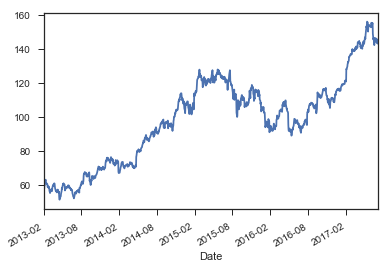

In [29]:
#test to see if all the data is there (2013-current) 
df.aapl_adj.plot();

## Checkpoint 

At this point we have scraped all the data we need from Yahoo Finance. We origanized it into a dataframe where the columns are our universe of stocks (names variable) and rows are dates. We can now do the math! 

# Z-Scores 

A z-score is a useful statistic which indicates how many standard deviations an element is from the mean.  It can be calculated from the following formula:

$$ Z = \frac{X - μ}{σ} $$

Where z is the z-score, $X$ is the value of the element, $μ$ is the population mean, and $σ$ is the standard deviation. The z-score allows us to calulate the probability of the value X occuring in an normal distribution. If we have a Z-score of 2, that means we constrain the normal distribution by 2 standard deviations, and 95.4% of the data falls within those constraints. There is only a 4.6% chance that data will fall outside of those bounds.

A random variable here is described by a normal distribution: 

<img src='https://i0.wp.com/i887.photobucket.com/albums/ac73/archaeopteryx1/bell-curve.jpg' height="542" width="542">

And here is some raw stock data: 

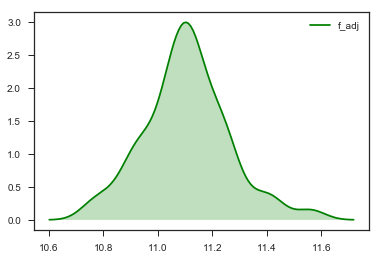

In [30]:
#<img src='http://access-excel.tips/wp-content/uploads/2015/09/z-score-02.png'  height="542" width="542">
sb.kdeplot(df['f_adj'][0:50], color="g", shade=True)

This is a kernel density estimation (probability density function) of Ford stock from the past 50 days. Notice any similarities?  

A stock is typically assumed to be a normal distribution, and so we can apply the Z-score idea and other statistical analyis. If a stock price falls outside of the Z-bounds we set, then there is a high probability it is over/undervalued. The market should then correct itself to a more stable value. One might say, its regressing to the mean :)

In reality a stock is actually a fat-tailed distribution with incoming prices having some correlation to the prices which came right before it. We could transform it, but thats for another project. 

So our goal then is to figure out what the optimial bounds are per stock to make the most money. Volatility and liquidity might play into this. Once we know the optimal bounds we have quantitative evidence of when a stock is absurdly priced, leading us to buy or sell. When we combine this with out intuition of the strength of a company, we build a strong portfolio evaluation scheme. 

### Notes before we proceed: 

I should note, that many of the trends in this analysis are already well priced into the stock. Professional quants have discovered this stuff a while ago. But for the hobby trader, using this statiscal tool in addition to intuitive judgements would hopefully make for better trading. To be safe, I would apply the suggestions from these stocks to highly liquid stocks, so that trades execute quicker. And of course, avoid a concentrated portfolio. 

# Time for the analysis.

I start by creating a moving average and moving standard-deviation thresholds of a stock, and map the real price to these smoothed prices. I then multiply the smoothed curves by a z-score factor which push the buy/sell thresholds further away from the mean.  If the real stock crosses these thresholds, then that is a trigger signal that we should buy or sell the stock.  These triggers are dynamic, and automatically adjust themselves to incoming stock information.

After a bunch of optimizaiton and fine tuning on historical traning data, and we get the best z-scores and window sizes for the moving averages, all in a neat little dataframe. We can use this metadata for trading. 

# All Stock Grid Search against all  hyperparameters (z scores, rolling window)

The next step is to take these 3 hyperparamters - two Z-scores and rolling window size - and perform a grid search to find the best values, trained on each stock's historical data. 

### WARNING: 

only run if you want to retune. Not advised, since it takes a very long time to process. Only retune if you are testing a new hypothesis. The model is already tuned, so rerunning on the same hypothesis wouldn't yeild much, and it will just slow your computer down for 3 hours. 

**scroll down to the next cell to view the analysis**

In [31]:
plotEachON = False #Toggle these if you need to reoptimize/tune 
plotFinalON = False 
small_test = False  
tune = False

########### Hyper Parameters ##############
if small_test == True: 
    #smaller batch of hyperparams for quicker testing 
    up_thresholds  = [1.0, 1,4, 1.8, 2.4] 
    low_thresholds  = [1.0, 1,4, 1.8, 2.4]
    rolling_windows = [40,100, 220, 300]
else:
    up_thresholds  = [1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4] 
    low_thresholds  = [1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4]
    rolling_windows = [10, 20, 40, 60, 80, 100, 120, 150, 200, 220, 240, 260, 280, 300]
#################################################

#### don't process stocks we've already done ####
existingfiles = [f for f in os.listdir(hyperpath) if os.path.isfile(os.path.join(hyperpath, f))]
working_df = df.copy() #a dataframe that drops all stocks we already processed 
if tune == True: 
    for SOI in df.columns: 
        SOI_test = '_' + SOI
        for existing_stock_name in existingfiles: 
            if SOI_test in existing_stock_name:
                #print SOI, 'exists'
                working_df = working_df.drop([SOI], axis=1)
#     working_df = working_df.drop(['dvn_adj'], axis=1) #does not work...
####################################################
    
    r_cols = ['window_size', 'up_z', 'low_z', '1000_today',
                  'inc_per_share', 'avg_p_change', 'days_per_hold',
                  'trades_per_year', 'earnings_per_year'] #for analysis later 
    
    main_start = time.time() #for whole program 
    for SOI in working_df.columns: #change to 'df' for all stocks in question
        print SOI
        start = time.time() #reset timer for new stock  
        result_array = np.empty((0, 9)) #intialize 
        for win, rolling_window in enumerate(rolling_windows):
            for up_threshold in up_thresholds: 
                for low_threshold in low_thresholds:
                    try: 
                        roll_array = [SOI+'_roll_2_above',SOI+ '_roll_2_below']
                        rolling_df=pd.DataFrame() #save rolling data to new dataframe
                        #WEIGHED
                        roll_avg = weighted_ma(df[SOI], 20)
                        #UNWEIGHTED
#                         roll_avg = df[SOI][::-1].rolling(window=rolling_window,
#                                                          min_periods=rolling_window).mean()[::-1] #rolling mean 
                        roll_std = df[SOI][::-1].rolling(window=rolling_window,
                                                         min_periods=rolling_window).std()[::-1] #rolling std dev

                        roll_2_above = roll_avg+(up_threshold*roll_std)
                        roll_2_above = pd.Series.to_frame(roll_2_above, roll_array[0])
                        roll_2_below = roll_avg-(roll_std*low_threshold)
                        roll_2_below = pd.Series.to_frame(roll_2_below, roll_array[1])
                        frames = [df[SOI], roll_2_above, roll_2_below]
                        rolling_df = pd.concat(frames, axis=1)
    #                     print rolling_df.head(120)

                        #check if the current prices lay within critical buy/sell thresholds?
                        rolling_df_columns = [SOI, SOI+'_buy', SOI+'_sell' ]
                        rolling_df_bin = pd.DataFrame(columns=rolling_df_columns, index=df.index)
                        rolling_df_bin[SOI] = df[SOI]
                        rolling_df_bin[SOI+'_buy'] = rolling_df[SOI] < rolling_df[SOI+'_roll_2_below']
                        rolling_df_bin[SOI+'_sell'] = rolling_df[SOI] > rolling_df[SOI+'_roll_2_above']  
    #                     print rolling_df_bin.head(100)
    #                     print rolling_df_bin.describe()

    ##########################################################################################################
                        ### Quantify perfomance of different hyperparamter combos ###
                        quant = rolling_df_bin.copy()
    #                     delete_cols=[]
    #                     for i, col in enumerate(rolling_df_bin.columns): 
    #                         if SOI not in col:
    #                             delete_cols.append(i)
    #                     quant = quant.drop(quant.columns[delete_cols], axis=1) 

                        num = pd.Series(data=np.arange(quant.shape[0]), index=df.index) 
                        num = pd.Series.to_frame(num, 'num') #add numerical index column (used to filter later)
                        quant = pd.concat([quant, num], axis=1)

                        quant = quant.ix[quant[SOI+'_buy']+quant[SOI+'_sell'] > 0] #remove days within z-bounds
                        quant = quant.sort_index(ascending=True) #change sorting for cleaning algorithm
    #                     print quant.head(5)

                        old_buy = False 
                        old_sell = False 
                        keep_rows=[]
                        for index, row in (quant.iterrows()): #only keep first sell/trade days
                            new_buy = row[1] 
                            new_sell = row[2]
                            num = row[3] #numerical index 
                            #print new_buy, new_sell
                            if old_buy==False  and new_buy!=False: #set flag to remove duplicate buy notifications
                                keep_rows.append(num)    
                            if old_sell==False and new_sell!=False: #set flag to remove duplicate sell notifications
                                keep_rows.append(num) 
                            old_buy = new_buy #shift 
                            old_sell = new_sell
                        quant = quant[quant['num'].isin(keep_rows)]
                        quant = quant.sort_index(ascending=False) #revert to normal sorting
                        #we now have an ordered buy/sell historical profile 
    #                     print quant.head(5)

                        old_num = 0
                        old_price = 0
                        price = 0
                        percent_compiler = []
                        for index, row in (quant.iterrows()): #performace calulations            
                            value = row[0]
                            buys = row[1]
                            sells = row[2]
                            num = row[3]
                            try:
                                delta = num - old_num
                                if delta == 0: #occurs on day 0 (today) trades. Prevent 0 division error  
                                    delta += 1
                                if buys==True: 
                                    old_price = value
                                if sells==True:
                                    price = value
                                gain = price-old_price
                                #print price, old_price, delta, value, num
                                if (buys == True): 
                                    quant.set_value(index, 'delta', delta) #add in delta between trades
                                    quant.set_value(index, 'gain', gain) 
                                    percent = gain/old_price
                                    quant.set_value(index, 'percent', percent)
                                    percent_compiler.append(percent)
                                else:
                                    quant.set_value(index, 'delta', np.nan)
                                    quant.set_value(index, 'gain', np.nan)
                                    quant.set_value(index, 'percent', np.nan)
                                old_num = num
                            except KeyError:
                                continue 
                        ip1k = 1000 #seed 
                        for i, p in enumerate(percent_compiler):
                            ip1k = ip1k*(1+p) #$1000 invested today would be  
                        try:
                            ips = quant['gain'].sum() #increase per share
                            apc = quant['percent'].mean() #average percent change
                            dph = quant['delta'].mean() #days per holding
                            tpy = 260.0/dph #trades per trading year (260 days)
                            check = 1*(1+(apc/tpy))
                        except KeyError: #usually occurs on 'gain' calc 
                            continue
                        if check > 0: 
                            epy = (1*(1+(apc/tpy))**tpy)-1 #avg earnings per year (interest formula)
                        else: 
                            epy = 'NaN' #avoid negative number^fractional exponent error (drop later)
                        results = [rolling_window,
                                   up_threshold,
                                   low_threshold,
                                   ip1k,
                                   ips,
                                   apc,
                                   dph, 
                                   tpy,
                                   epy]
                        result_array = np.append(result_array,[results],axis=0) #convert to np array
                        if plotEachON == True:     #Plot deterministic plot and results of grid search
                            fig = plt.figure(figsize=(14, 5))
                            ax0 = fig.add_subplot(1,1,1)
                            ax0.plot(df[SOI])
                            r2a = '%s_roll_2_above' % SOI 
                            r2b = '%s_roll_2_below' % SOI
                            ax0.plot(rolling_df[r2b], color=(rgb(255), rgb(102), rgb(102), 0.4))
                            ax0.plot(rolling_df[r2a], color=(rgb(28), rgb(232), rgb(174), 0.4))
                            plt.scatter(quant.index, quant[SOI+'_buy'], s=40, c='red')
                            plt.scatter(quant.index, quant[SOI+'_sell'], s=40, c='lime')
                            plt.title(SOI + str(rolling_window) +' days')
                            plt.show()
                    
                    except Exception as e: #if all else fails...
                        print e 
                        
        results_hyper = pd.DataFrame(result_array, columns=r_cols)
#         print results_hyper.head(4)
        filename = 'results_hyper_' + SOI +'.csv'
        fullpath = os.path.join(hyperpath, filename)
        results_hyper.to_csv(fullpath) #for safe keeping :)
        print 'finished  %s! In %f sec' % (SOI, (time.time() - start))
    print 'finished everything!'
    print 'finished  %s! In %f sec' % ('all stocks', (time.time() - main_start))
else: 
    print 'no need, hyperparameters tuned'

no need, hyperparameters tuned


# Exploratory Analysis of optimized hyperparameters and results 

The numbers are crunched. Lets plot probability density functions of hyperparameters and rank results. 

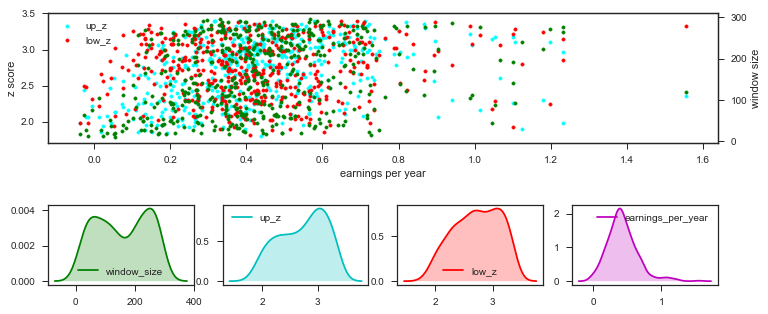

       window_size   up_z  low_z  1000_today  inc_per_share  avg_p_change  \
count       487.00 487.00 487.00      487.00         487.00        487.00   
mean        157.62   2.72   2.73    1,530.88          33.04          0.47   
std          87.96   0.42   0.40      373.73          49.94          0.29   
min          10.00   1.80   1.82        0.00         -74.94         -0.04   
25%          78.00   2.36   2.42    1,338.73          12.32          0.29   
50%         153.00   2.78   2.74    1,488.63          22.71          0.43   
75%         240.00   3.07   3.08    1,669.77          37.15          0.59   
max         296.00   3.40   3.40    3,961.58         777.96          2.14   

       days_per_hold  trades_per_year  earnings_per_year  
count         487.00           487.00             487.00  
mean          307.84             1.69               0.43  
std           197.87             1.81               0.22  
min            25.00             0.26              -0.04  
25%        

,SOI,window_size,up_z,low_z,1000_today,inc_per_share,avg_p_change,days_per_hold,trades_per_year,earnings_per_year
406,stx_adj,120.00,2.36,3.32,"2,315.57",24.12,1.32,177.00,1.52,1.55
40,apc_adj,264.00,1.98,3.14,"2,160.62",37.74,1.16,225.60,1.15,1.23
437,ual_adj,276.00,2.96,2.86,"1,962.73",36.34,0.96,114.50,2.27,1.23
231,incy_adj,272.00,3.10,2.24,"2,231.76",82.35,1.23,277.00,0.94,1.20
1,aal_adj,224.00,2.30,3.24,"2,008.58",24.04,0.92,105.20,3.11,1.18
318,nfx_adj,240.00,1.90,2.80,"1,892.50",20.98,0.89,115.30,2.41,1.12
166,expe_adj,92.00,3.10,3.28,"2,683.99",76.93,1.68,508.80,0.51,1.11
429,tsla_adj,142.00,2.26,3.22,"1,856.98",126.82,0.86,91.00,5.38,1.10
317,nflx_adj,192.00,3.18,1.92,"2,353.18",61.93,1.35,349.80,1.33,1.10
272,lrcx_adj,197.00,2.60,3.06,"2,327.01",81.08,1.33,396.00,0.66,1.07


In [33]:
independent = 'earnings_per_year' #independent variable to analyze on 
plotEach = False
plotFinal = True 
epy_std_thresh = 0.15 #std dev threshold of earnings per year % that must be exceed to warrant drop
analysis_rows = 10 #num of top performing rows to include in analysis
cols = [u'window_size', #0
        u'up_z',#1
        u'low_z', #2
        u'1000_today',#3
        u'inc_per_share',#4
        u'avg_p_change', #5
        u'days_per_hold',#6
        u'trades_per_year',#7
        u'earnings_per_year']#8
trades_list = np.empty((0,9)) 
t_cols = [u'window_size', u'up_z', u'low_z', u'earnings_per_year'] #top.columns
soi_list = []

for i, SOI in enumerate(df.columns): 
    filename = 'results_hyper_' + SOI + '.csv' 
    fullname = os.path.join(hyperpath, filename)
    if os.path.isfile(fullname) == False: #see if path exists 
        #print SOI, 'file does not exist'
        continue 
    results_hyper = pd.read_csv(fullname)
    results_hyper = results_hyper.drop(['Unnamed: 0'], axis=1)
    results_hyper = results_hyper.dropna()
    results_hyper = results_hyper.sort_values(by=independent, ascending=False)
    #results_hyper = results_hyper.drop(results_hyper.columns[[3,4,5,6,7]], axis=1)
    t_cols = results_hyper.columns
    #print SOI
    #print results_hyper.head(5)
    #print results_hyper.tail(5)
    
    top = results_hyper[:analysis_rows] #number of top performing combos to analyze 
    top_std = top.std()
    i = 0 
    while (True): #parse out overfitted hyperparameter combos
        top = results_hyper[i:i+analysis_rows] #remove top performing row (overfitted), alter if there is more than one 
        top_std = top.std()
        i+= 1
        if i > 1: 
            #print SOI, '\n', top, top_std, '\n' # see which stocks needed adjustment 
            pass 
        if top_std[independent] < epy_std_thresh:
            break 
    t = [top.mean()]
    soi_list.extend([SOI])
    trades_list = np.append(trades_list, t,axis=0) #append top results to trades df 
    
    if plotEach == True:     
        fig = plt.figure(figsize=(21, 7))
        ax0 = plt.subplot2grid((2,3), (0,0), colspan=3)
        ax0.plot(df[SOI])
        r2a = SOI+ '_roll_2_above'
        r2b = SOI+ '_roll_2_below'
        #ax0.plot(rolling_df[r2b], color=(rgb(255), rgb(102), rgb(102), 0.4))
        #ax0.plot(rolling_df[r2a], color=(rgb(28), rgb(232), rgb(174), 0.4))
        plt.title(SOI)

        ax1 = plt.subplot2grid((2,3), (1,0), colspan=1)
        ax1 = sb.boxplot(y="window_size", x = independent, data=top, orient='h')
    #   plt.scatter(results_hyper['earnings_per_year'], results_hyper['window_size'], s=20, c='red')
        ax1.set_ylabel('rolling window day size')
        ax1.set_xlabel(independent)
        ax1.legend(loc=2)
        
        ax2 = plt.subplot2grid((2,3), (1,1), colspan=1)
        ax2 = sb.boxplot(y="up_z", x = independent, data=top, orient='h')

        ax3 = plt.subplot2grid((2,3), (1,2), colspan=1)
        ax3 = sb.boxplot(y="low_z", x = independent, data=top, orient='h')
    #    plt.scatter(results_hyper[independent], results_hyper['up_z'], s=20, c='blue')
    #    plt.scatter(results_hyper[independent], results_hyper['low_z'], s=20, c='lime')
        ax2.legend(loc='best')
        plt.show()

trades = pd.DataFrame(data=trades_list, columns=t_cols)
soi_names = pd.DataFrame(data=soi_list, columns=['SOI'])
trades = pd.merge(soi_names, trades, how='outer', left_index=True, right_index=True)
trades = trades.sort_values(by=independent, ascending=False)
trades = trades.drop(trades.index[0]) #drop insanely good BRK stock 

if plotFinal == True: 
    fig = plt.figure(figsize=(12, 5))
    ax0 = plt.subplot2grid((4,4), (0,0), colspan=4, rowspan=2)
    plt.scatter(trades[independent], trades['up_z'],s =12,  c='cyan')
    plt.scatter(trades[independent], trades['low_z'],s =12,  c='red')
    plt.ylabel('z score')
    plt.xlabel('earnings per year')
    plt.legend()
    ax1 = ax0.twinx()
    plt.scatter(trades[independent], trades['window_size'], s=12, c='green')
    plt.ylabel('window size')
    
    ax2 = plt.subplot2grid((3,4), (2, 0), colspan=1)
    sb.kdeplot(trades['window_size'],legend=True, shade=True, color='g', vertical=False) #sb KDE 
    ax3 = plt.subplot2grid((3,4), (2, 1), colspan=1)
    sb.kdeplot(trades['up_z'],legend=True, shade=True, color='c', vertical=False) #sb KDE 
    ax4 = plt.subplot2grid((3,4), (2, 2), colspan=1)
    sb.kdeplot(trades['low_z'],legend=True, shade=True, color='r', vertical=False) #sb KDE 
    ax5 = plt.subplot2grid((3,4), (2, 3), colspan=1)
    sb.kdeplot(trades['earnings_per_year'],legend=True, shade=True, color='m', vertical=False) #sb KDE 
    
    plt.show()

trades.to_csv('data/trades.csv') #for safe keeping :)
print trades.describe()
trades.head(10)

### What are we looking at? 

The Dataframe above shows us some stats. For each stock, we get the optmized window size, z-score bounds, and earnings statistics. We should be cautious of the first couple of trades that are way more sucessful than the others, since they may be overfit/outliers. This is why seeing the distributions in the charts is useful. 

The scatter plot shows the range of the hyperparameters (z-bounds, rolling window size) vs. average earnings per year. We can see some clustering. Window size is bimodal, and if we throw out low values (overfit, generally around 10-20 day windows) There is a peak around 220 days. Both upper and lower z-score bounds tend towards a score of 3, but in a non-normal distribution with high variance. Finally earnings per share is around 40%, which is a great ROI. Too great. We should be weary of overfitting the model since this is only training data. We'll have to validate and test later. It'll be tricky since we don't have much data to work with...

# Calculate stocks that are awaiting a trade

Intial Analysis looks good! Let's see what stocks the algrithim deems under/overvalued based on the results. We can use this as informed buy/sell trading signals. 

In [34]:
trades_calc = trades.set_index('SOI') #set both index SOI to easily grab key values 
trades_calc = trades_calc.transpose() #for ease of iterations
a = []
up_leeway = 1
low_leeway = 1
print 'up leeway: ', up_leeway
print 'low leeway: ', low_leeway

for SOI in trades_calc.columns: 
    window = int(trades_calc[SOI]['window_size']) #optimized hyperparameters 
    up_z = trades_calc[SOI]['up_z']
    low_z = trades_calc[SOI]['low_z']
    epy = trades_calc[SOI]['earnings_per_year']
    tpy = trades_calc[SOI]['trades_per_year']
    ROI = df[SOI][:window] #region of interest is size of optimized window 
    current_price = current[SOI][0] #float of current price 
    
    up_thresh = mean = ROI.mean()+ROI.std()*up_z
    low_thresh = mean = ROI.mean()-ROI.std()*low_z
    
    #buy/sell triggers 
    if current_price<(low_thresh*low_leeway):
        buy=1
        queue_b = 1
    else:
        buy='NaN'
        queue_b = 0      
    if current_price>(up_thresh*up_leeway):
        sell=1
        queue_s = 1
    else:
        sell='NaN'
        queue_s = 0
    queue = queue_b+queue_s
    
    values = [current_price, up_thresh, low_thresh, tpy, epy, buy, sell, queue]
    a.append(values)
index = ['current_price', 'up_thresh', 'low_thresh', 'trades_per_year', 'earnings_per_year', 'buy', 'sell', 'queue']   
stock_stats = pd.DataFrame(data=np.array(a).T, index=index, columns=trades_calc.columns)

stock_stats_vis = stock_stats.transpose() #visualization options 
stock_stats_vis = stock_stats_vis[stock_stats_vis['queue'] != '0']
buys = stock_stats_vis[stock_stats_vis['buy'] != 'NaN'] #buys only 
sells = stock_stats_vis[stock_stats_vis['sell'] != 'NaN'] #buys only 

## TO DO ##
# comment these out (one at a time) to see buys only, sells only, or both. 
stock_stats_vis
#sells
#buys

up leeway:  1
low leeway:  1


,current_price,up_thresh,low_thresh,trades_per_year,earnings_per_year,buy,sell,queue
SOI,,,,,,,,
stx_adj,34.424904,51.7130389986,34.6697129528,1.51752454993,1.55377882257,1,NaN,1
nflx_adj,96.5,183.470336428,115.256879516,1.33188561034,1.10078951781,1,NaN,1
swks_adj,66.307276,114.389150958,95.810498875,0.618520354872,1.04485381919,1,NaN,1
chtr_adj,264.119995,355.762832015,306.65040664,0.893839239388,0.992202894762,1,NaN,1
idxx_adj,109.970001,181.946286216,140.536062894,0.45047498001,0.86716109871,1,NaN,1
mlm_adj,174.330185,245.445128411,199.01813647,1.07507154465,0.836777373578,1,NaN,1
csx_adj,27.538843,59.0832778847,41.0243988756,0.955016184074,0.819718772209,1,NaN,1
alb_adj,76.025065,116.828422075,97.2825067211,0.553191489362,0.764955496916,1,NaN,1
etfc_adj,26.549999,41.8602626546,27.5958934242,1.02735150281,0.740404392155,1,NaN,1


# To check specific scores

Seeing the global averages is useful to get a guage for the general health of the model, but it would be nice to see scores and predictions on specific stocks. This is especially true since this model is intended for the personal/hobby trader, and not a full fledged hedge fund. I say that because a hedge fund has the resources and capital to invest into a broad portofolio, but smaller scale traders would need to pick stocks with more discretion and would likeley end up with a more concentrated portfolio. So lets built those functions. 

In [35]:
# quick peek at the data, stats values
def peek_raw_data(stock_list):
    for SOI in stock_list:
        print SOI + ' analysis'
        name = 'results_hyper_'+SOI+'_adj.csv'
        name = os.path.join(hyperpath, name)
        return pd.read_csv(name)



# only look at the specific scores of interst 
def check_score_simple(stock_list):
    for SOI in stock_list:
        SOI = SOI+'_adj'
        window = int(trades_calc[SOI]['window_size']) #optimized hyperparameters 
        up_z = trades_calc[SOI]['up_z']
        low_z = trades_calc[SOI]['low_z']
        epy = trades_calc[SOI]['earnings_per_year']
        print '\n', SOI
        print 'window: ', window
        print 'up_z: ', up_z
        print 'low_z: ', low_z
        print 'epy: ', epy
        
        
        
#view top results from optimization 
def check_top_results(stock_list):
    for SOI in stock_list:
        filename = 'results_hyper_' + SOI + '_adj.csv' 
        fullname = os.path.join(hyperpath, filename)
        if os.path.isfile(fullname) == False: #see if path exists 
            #print SOI, 'file does not exist'
            continue 
        results_hyper = pd.read_csv(fullname)
        results_hyper = results_hyper.drop(['Unnamed: 0'], axis=1)
        results_hyper = results_hyper.dropna()
        results_hyper = results_hyper.sort_values(by=independent, ascending=False)
        #results_hyper = results_hyper.drop(results_hyper.columns[[3,4,5,6,7]], axis=1)
        print SOI 
        print results_hyper.head(5)
        print 
        
        
#plot a specific stock with z-score bounds visible     
def plot_stocks(stock_list):
    for SOI in stock_list:
        SOI = SOI + '_adj'
        print SOI
        window = int(trades_calc[SOI]['window_size']) #optimized hyperparameters 
        up_z = trades_calc[SOI]['up_z']
        low_z = trades_calc[SOI]['low_z']
        epy = trades_calc[SOI]['earnings_per_year']

        roll_avg = df[SOI][::-1].rolling(window=window, min_periods=window).mean()[::-1] #rolling mean 
        roll_std = df[SOI][::-1].rolling(window=window, min_periods=window).std()[::-1] #rolling std dev
        roll_z_above = roll_avg+(up_z*roll_std)
        roll_z_below = roll_avg-(low_z*roll_std)

        ### PLOT FIGURE ###
        fig = plt.figure(figsize=(14, 5))   
        ax1 = fig.add_subplot(1,1,1)
        fig.autofmt_xdate() #rotate date labels 
        title = 'Analysis of  ' + SOI
        plt.title(title)

        ax1.plot(df[[SOI]]) #time wise plot
        ax1.plot(roll_avg, color=(rgb(211), rgb(236), rgb(245))) #MEAN 
        ax1.plot(roll_z_above, color='cyan')
        ax1.plot(roll_z_below, color='red')

        #LEGEND 
        up_name = 'upper_z: '+str(up_z)
        low_name = 'lower_z: '+str(low_z)
        window_name = 'window_size: '+str(window)
        epy_name = 'historic epy: ' + str(epy)
        cyan_patch = mpatches.Patch(color='cyan',
                                    label=up_name)
        red_patch = mpatches.Patch(color='red',
                                   label=low_name)
        win_patch = mpatches.Patch(color='green', label=window_name)
        epy_patch = mpatches.Patch(color='m', label=epy_name)

        plt.legend(handles=[cyan_patch, red_patch, win_patch, epy_patch], loc='best')
        plt.show()



## Play around with graphs!

change the value of the SOI list to plot your specific stocks of interst. 

tsla_adj


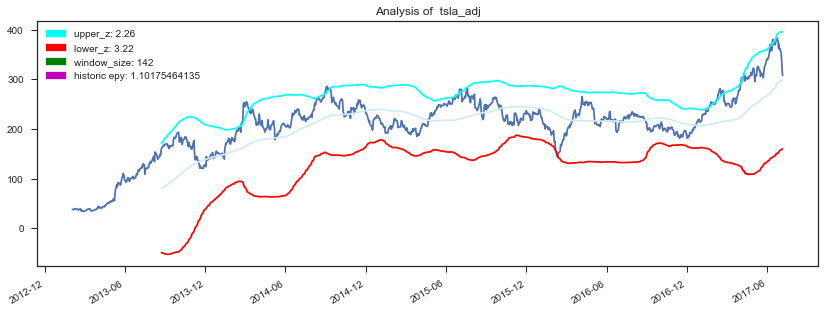

In [47]:
SOI = ['tsla']
#peek_raw_data(SOI);
#check_score_simple(SOI);
#check_top_results(SOI);
plot_stocks(SOI)

Or just plot all the buy/sell signals. 

In [ ]:
stock_stats_trade_list = buys.transpose()
#stock_stats_trade_list = stock_stats_trade_list.columns

for SOI in stock_stats_trade_list.columns:
    print SOI
    window = int(trades_calc[SOI]['window_size']) #optimized hyperparameters 
    up_z = trades_calc[SOI]['up_z']
    low_z = trades_calc[SOI]['low_z']
    epy = trades_calc[SOI]['earnings_per_year']
    
    roll_avg = df[SOI][::-1].rolling(window=window, min_periods=window).mean()[::-1] #rolling mean 
    roll_std = df[SOI][::-1].rolling(window=window, min_periods=window).std()[::-1] #rolling std dev
    roll_z_above = roll_avg+(up_z*roll_std)
    roll_z_below = roll_avg-(low_z*roll_std)
    
    ### PLOT FIGURE ###
    fig = plt.figure(figsize=(14, 5))   
    ax1 = fig.add_subplot(1,1,1)
    fig.autofmt_xdate() #rotate date labels 
    title = 'Analysis of  ' + SOI
    plt.title(title)

    ax1.plot(df[[SOI]]) #time wise plot
    ax1.plot(roll_avg, color=(rgb(211), rgb(236), rgb(245))) #MEAN 
    ax1.plot(roll_z_above, color='cyan')
    ax1.plot(roll_z_below, color='red')
    
    #LEGEND 
    up_name = 'upper_z: '+str(up_z)
    low_name = 'lower_z: '+str(low_z)
    window_name = 'window_size: '+str(window)
    epy_name = 'historic epy: ' + str(epy)
    cyan_patch = mpatches.Patch(color='cyan',
                                label=up_name)
    red_patch = mpatches.Patch(color='red',
                               label=low_name)
    win_patch = mpatches.Patch(color='green', label=window_name)
    epy_patch = mpatches.Patch(color='m', label=epy_name)
    
    plt.legend(handles=[cyan_patch, red_patch, win_patch, epy_patch], loc='best')
    plt.show()

## Weighted Moving Averages

Tested this to replace the python simple moving average function. It did not change the results much. Bugs inherent to custom functions; not worth implementing. 

In [ ]:
# CODE IN PROGRESS

#********************************* Create Weighed Moving Average Functions *********************************
#testing some different weight patterns 

def fibonacci_weights(n):
    fib = np.zeros(shape=(n))
    golden_ratio = (1 + np.sqrt(5)) / 2
    for weight in range(n):
        val = (golden_ratio**(weight+1) - (1 - golden_ratio)**(weight+1)) / np.sqrt(5)
        fib[weight] = round(val)
    return fib #array of fibonacci weights, len==kernel size 

def linear_weights(n):
    weights = np.linspace(0, n-1, n)
    return weights #array of linear weights, len==kernel size 

def exponential_weights(n):
    weights = np.linspace(0, n-1, n)
    weights = weights*weights
    return weights #array of linear weights, len==kernel size 

def weighted_ma(vec, k): #array to convolve, kernel size 
    #a weighted moving average which uses a custom sequences convolve weights over
    convolution = linear_weights
    vec = vec[::-1] #sort stock data by most recent first 
    weights = convolution(k) #create fibo weights 
    wma = np.zeros(shape=(len(vec)))
    for i, _ in enumerate(vec): #convolution
        if i == 0: #operand issue 
            window = vec[(-k-i):]
        else: 
            window = vec[(-k-i):-i]
        if len(window) < k: #no padding
            break
        fx = (sum(window*weights)) / sum(weights) #compute weighted average
        wma[i] = fx #append to new array 
    return wma 

# ******************** TEST HERE **********************************

k = 20 #kernel size 
#test = np.linspace(0, 50-1, 50)
test = df['tsla_adj']
index = df.index
plot_size_min = 0
plot_size_max = -1

wma = weighted_ma(test, k)
#wma = pd.DataFrame(data=wma, index=df.index)#[:100])

std = test[::-1].rolling(window=100, min_periods=100).std().values
std_p = pd.DataFrame(data=(wma + (1*std[::-1])), index=index)
std_m = pd.DataFrame(data=(wma - (1*std[::-1])), index=index)


fig = plt.figure(figsize=(21, 7))
ax1 = fig.add_subplot(1,1,1)

#WEIGHTED 
ax1.plot(test[plot_size_min:plot_size_max], c = 'green')
ax1.plot(pd.DataFrame(wma, index=index)[plot_size_min:plot_size_max], c = 'blue')
#ax1.plot(std_p[plot_size_min:plot_size_max], c = 'red')
#ax1.plot(std_m[plot_size_min:plot_size_max], c = 'red')

#UNWEIGHTED
mean = test[::-1].rolling(window=40, min_periods=40).mean()[::-1]
std = test[::-1].rolling(window=40,  min_periods=40).std()[::-1]
ax1.plot(mean[plot_size_min:plot_size_max], c = 'cyan')
#ax1.plot((mean+std*2)[plot_size_min:plot_size_max], c = 'purple')
#ax1.plot((mean-std*2)[plot_size_min:plot_size_max], c = 'purple') 

# New Research Questions: 

1) Detrend data by fitting linear regression. Subract this out from the raw price and optmize on these. Window size of lin-reg would now be an additional hyperparameter. 

2) Collect more data for validation/testing. 

    create a fake stock generator
        - use this to to create custom stock data with different characteristics 
        - volatility scale, bull/bear market, volume
            - volatility scale 
        - can then create models that train/test on these fake data 
        - these models will be generalized to particular profiles of stocks (see DL classifier)
        - avoids overfitting 
        - then categorize real stocks into these generalized profiles

3) Use k-means clustering on hyperparameters and learn if certain industries, company age etc. has a certain range for the hyperparameters. 

-----------------**Lower Priority**--------------------------

4) create inverse algo to short stocks (same idea as what you already have)
    
    -- kinda useless until I find a way to short my real money... 

3) don't buy on first crossing of threshold - wait for price undervaluation to increase over a few days of market selling

### Original Scraping method (dead with YF API )

In [ ]:
# NOW DEPRECATED. But thats ok. We have the data we need from this. 
#Scrape Stock Data from Yahoo Finance 
crawl = False #to prevent overwriting data 
add = False 
if crawl == True: 
    date_start = '2012-06-30'
    date_end = '2017-05-02'

    #stocks of interest not in sp500
    names = ['fb', 'inod']
    #names = ['tsla', 'lulu', 'onvo', 'yelp', 'twtr', 'z']
    #names = names+sp500+sp400
    print 'initializing...'
    delete_col = Share('aapl') #just to setup dataframe 'Date', pick stock with long history 
    df = delete_col.get_historical(date_start, date_end)[1:]
    df =  pd.DataFrame(df)
    df = df.drop(['Close', 'High', 'Low', 'Open', 'Symbol', 'Volume'], axis=1, inplace=False)
    df = df.rename(columns={'Adj_Close': 'delete_me'})

    for i, name in enumerate(names):
        print "collecting data: ", name 
        try: 
            share = Share(name)
            share_df = share.get_historical(date_start, date_end)[1:] #pull stock from api 
            share_df = pd.DataFrame(share_df) #turn into dataframe 
            share_df = share_df.drop(['Close', 'High', 'Low', 'Open', 'Symbol', 'Volume'], axis=1)
            names[i] = name + '_adj'
            share_df = share_df.rename(columns={'Adj_Close': names[i]})
            df = pd.merge(df, share_df, on='Date')
        except:
            print "data retreival error"
            pass
    df = df.drop(['delete_me'], axis=1)

    df.to_csv('stocks_temp.csv') #for safe keeping :) 
    print df.tail(2) #spot check 
    print df.head(2)
else: 
    print 'crawling is off'